In [1]:
import spacy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, hashing_trick, text_to_word_sequence
from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

c:\Users\kevin\anaconda3\envs\ml_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_amazon = pd.read_csv("amazon_cells_labelled.txt", sep="\t")
df_imdb = pd.read_csv("imdb_labelled.txt", sep="\t")
df_yelp = pd.read_csv("yelp_labelled.txt", sep="\t")


In [3]:
df_reviews = pd.concat([df_amazon, df_imdb, df_yelp])
df_reviews = df_reviews.sample(frac=1).reset_index(drop=True)
df_reviews

,reviews,sentiment
0,Also notable is John Bailey's fine crisp beaut...,1
1,Nice headphones for the price and they work gr...,1
2,"If you do go see this movie, bring a pillow or...",0
3,"REAL sushi lovers, let's be honest - Yama is n...",0
4,"Great product, fast shipping!.",1
...,...,...
2743,"Light weight, I hardly notice it is there.",1
2744,The chefs were friendly and did a good job.,1
2745,It's a feel-good film and that's how I felt wh...,1
2746,"The sets are so bad, they wouldn't look out of...",0


In [4]:
df_reviews.isnull().sum()

reviews      0
sentiment    0
dtype: int64

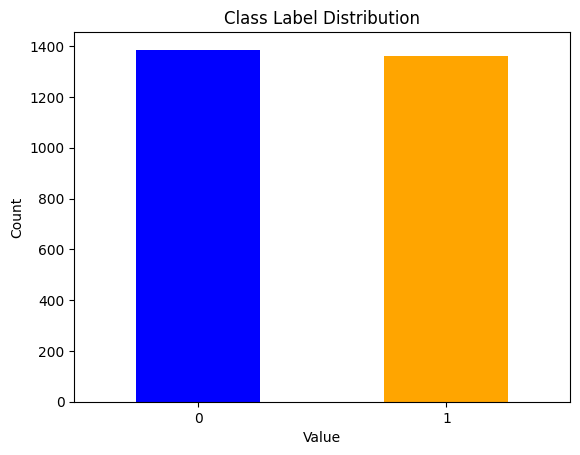

In [5]:
# Count the occurrences of 0 and 1 in the 'column_name'
counts = df_reviews['sentiment'].value_counts()

# Plot the bar chart
counts.plot(kind='bar', color=['blue', 'orange'])

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Class Label Distribution')

# Display the plot
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

In [6]:
nlp = spacy.load("en_core_web_sm")
def preprocessor(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ''.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text

In [7]:
df_reviews["preprocessed"] = df_reviews["reviews"].progress_apply(preprocessor)

my bar!: 100%|██████████| 2748/2748 [00:10<00:00, 259.19it/s]


In [8]:
df_reviews[df_reviews["sentiment"] == 1]

,reviews,sentiment,preprocessed
0,Also notable is John Bailey's fine crisp beaut...,1,notable john bailey s fine crisp beautifully c...
1,Nice headphones for the price and they work gr...,1,nice headphone price work great
4,"Great product, fast shipping!.",1,great product fast shipping
6,It's as continuously beautiful to look at as a...,1,s continuously beautiful look bertolucci relat...
7,They know how to make them here.,1,know
...,...,...,...
2742,"My breakfast was perpared great, with a beauti...",1,breakfast perpare great beautiful presentation...
2743,"Light weight, I hardly notice it is there.",1,light weight hardly notice
2744,The chefs were friendly and did a good job.,1,chef friendly good job
2745,It's a feel-good film and that's how I felt wh...,1,s feel good film s feel come cinema


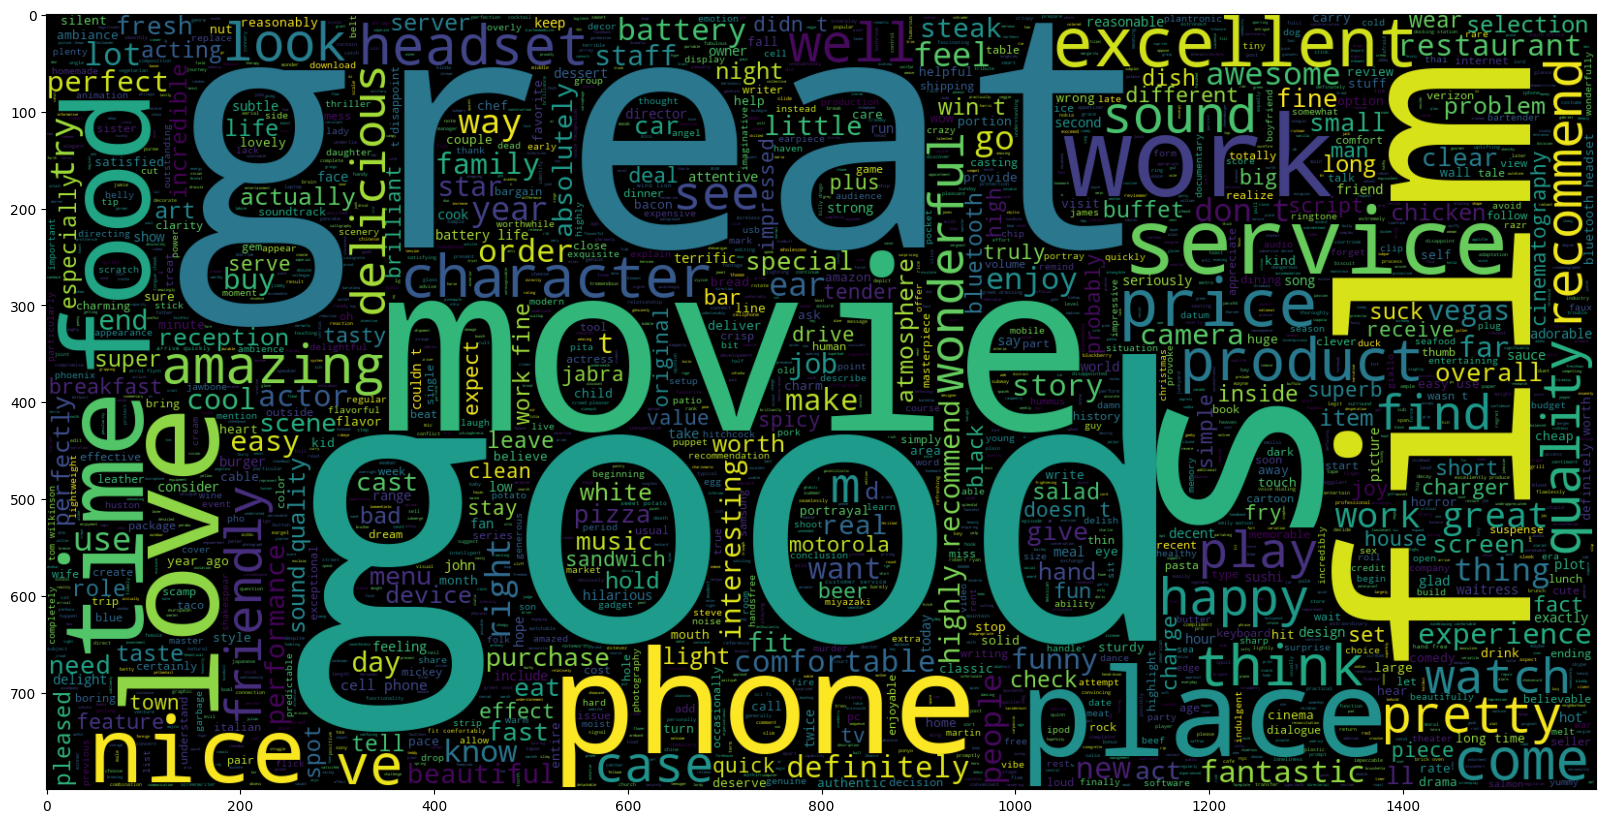

In [9]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_reviews[df_reviews.sentiment == 1].preprocessed))
plt.imshow(wc, interpolation = 'bilinear')

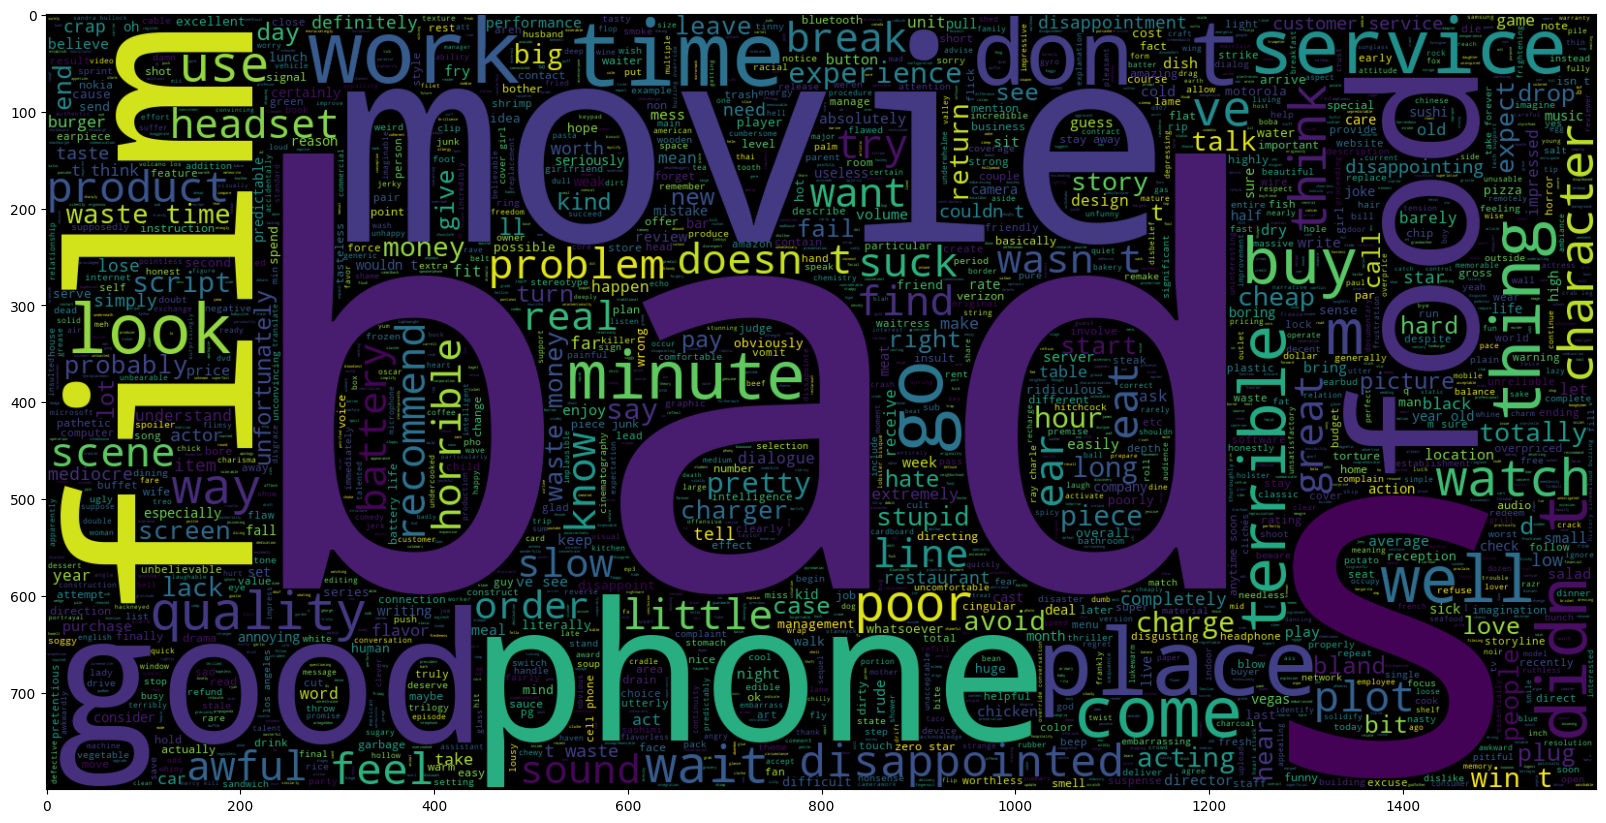

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_reviews[df_reviews.sentiment == 0].preprocessed))
plt.imshow(wc, interpolation = 'bilinear')

In [11]:
x = df_reviews["preprocessed"]
y = df_reviews["sentiment"].values

In [12]:
x_vect = [text.split() for text in x.tolist()]
DIM = 100
wv2_model = Word2Vec(sentences=x_vect, vector_size=DIM, window=10, min_count=1)

In [13]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_vect)
word_index = tokenizer.word_index
vocab_size=len(word_index) + 1
print("Vocab Size")
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(x_vect)
x = pad_sequences(sequences, maxlen=1000)

Vocab Size
4142


In [14]:
# Import tensor representations for words
vocab = tokenizer.word_index
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
    try:
      weight_matrix[i] = model.wv[word]
    except KeyError:
      pass
  return weight_matrix

In [15]:
embeddings_matrix = get_weight_matrix(wv2_model)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1000)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=DIM, input_length=1000, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         414200    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000, 256)         234496    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 817,209
Trainable params: 403,009
Non-trainable params: 414,200
_________________________________________________________________


In [24]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.3)

Epoch 1/10
43/43 [==============================] - 327s 8s/step - loss: 0.6927 - accuracy: 0.5260 - val_loss: 0.6954 - val_accuracy: 0.4766
Epoch 2/10
43/43 [==============================] - 316s 7s/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6951 - val_accuracy: 0.4766
Epoch 3/10
43/43 [==============================] - 326s 8s/step - loss: 0.6925 - accuracy: 0.5260 - val_loss: 0.6940 - val_accuracy: 0.4766
Epoch 4/10
43/43 [==============================] - 307s 7s/step - loss: 0.6925 - accuracy: 0.5260 - val_loss: 0.6946 - val_accuracy: 0.4766
Epoch 5/10
43/43 [==============================] - 308s 7s/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6962 - val_accuracy: 0.4766
Epoch 6/10
43/43 [==============================] - 320s 7s/step - loss: 0.6920 - accuracy: 0.5260 - val_loss: 0.6951 - val_accuracy: 0.4766
Epoch 7/10
43/43 [==============================] - 496s 12s/step - loss: 0.6919 - accuracy: 0.5260 - val_loss: 0.6947 - val_accuracy: 0.4766
Epoch 8/10
4

In [25]:
# List all physical devices (CPU and GPU)
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs found. TensorFlow is using CPU.")

TensorFlow is using the following GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


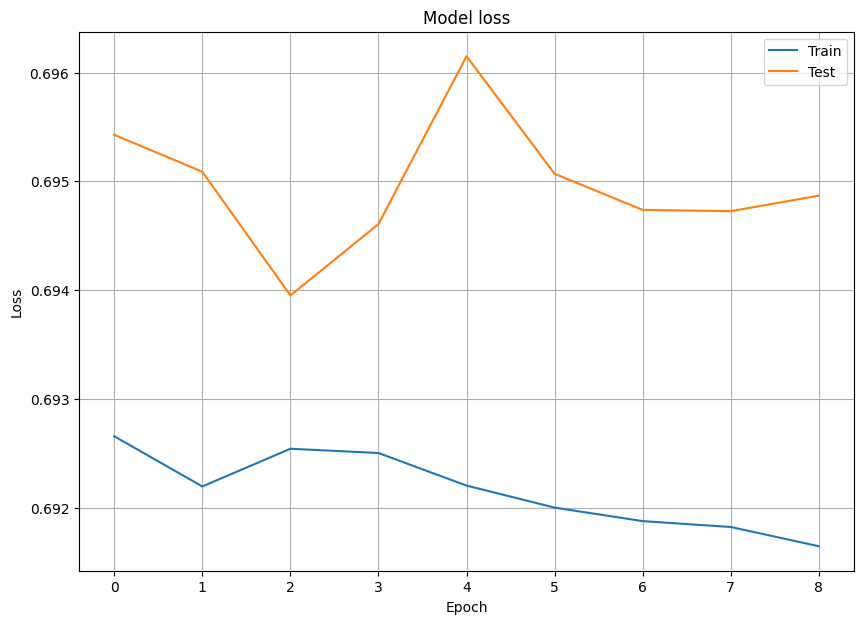

In [26]:
# Visualize the results:
plt.figure(figsize=(10, 7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

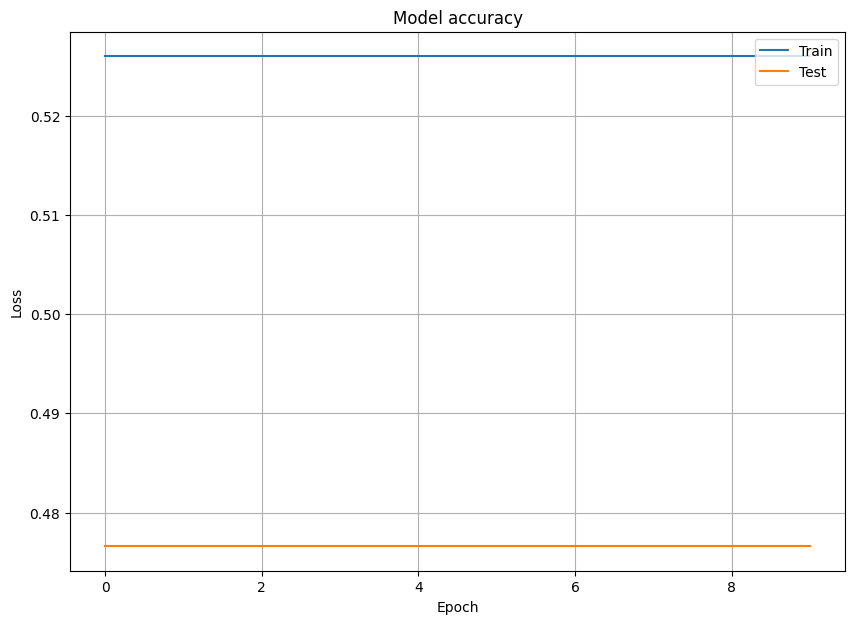

In [27]:
# Visualize the results:
plt.figure(figsize=(10, 7))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [28]:
# Save model
model.save("models/model2.keras")